## MVP for GrowBikeNet implementation

### User Input:

In [3]:
from networkx.algorithms.simple_paths import all_simple_edge_paths

city_name = 'Oelde'
seed_point_spacing = 1000 #distance between seed points
orig_crs = '4326'
proj_crs = '3857'
delta = 500 #maximal distance between seed point and actual point in OSM data

### Data from OSM

In [4]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.prepared import prep
from shapely.geometry import Point, LineString, MultiLineString
from scipy.spatial import cKDTree
import math
from itertools import combinations
from shapely.ops import unary_union
import networkx as nx
import matplotlib.pyplot as plt
import os
import cv2
import glob
import re
import pathlib

In [5]:
g = ox.graph_from_place(city_name, network_type='all')

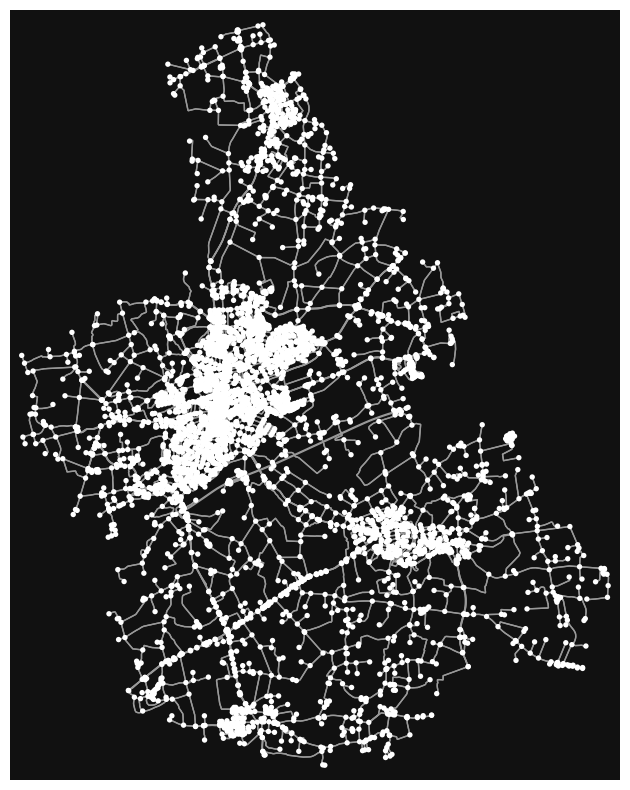

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [6]:
ox.plot_graph(g, figsize=(10, 10))

### Save Data

In [7]:
edges = ox.graph_to_gdfs(g, nodes=False, edges=True)

In [8]:
edges_gdf = gpd.GeoDataFrame(edges, crs=orig_crs)

In [9]:
edges_gdf

osmid       highway lanes maxspeed  \
u           v           key                                            
25270873    10207064748 0    1115969850     secondary     1       50   
            25270883    0     391936459     secondary     1      NaN   
25270874    499376113   0    1115969849     secondary     1       50   
            3710295455  0     391936459     secondary     1      NaN   
25270879    499376139   0      35815425  unclassified   NaN      NaN   
...                                 ...           ...   ...      ...   
13395239165 13395239161 0    1460511115       service   NaN      NaN   
13449603217 6354742567  0      33290693  unclassified     1      NaN   
            859535717   0      33290693  unclassified     1      NaN   
13521086485 429278914   0     683718160   residential   NaN      NaN   
            507623263   0      36687195   residential   NaN       30   

                                              name  oneway    ref reversed  \
u           v           key                                                  
25270873    10207064748 0    Keitlinghauser Straße    True  L 793    False   
            25270883    0                      NaN    True    NaN    False   
25270874    499376113   0             In der Geist    True  L 793    False   
            3710295455  0                      NaN    True    NaN    False   
25270879    499376139   0               Sudbergweg   False    NaN     True   
...                                            ...     ...    ...      ...   
13395239165 13395239161 0                      NaN   False    NaN     True   
13449603217 6354742567  0              Ernstingweg   False    NaN    False   
            859535717   0              Ernstingweg   False    NaN     True   
13521086485 429278914   0      Willy-Brandt-Straße   False    NaN     True   
            507623263   0      Willy-Brandt-Straße    True    NaN    False   

                                 length    junction  \
u           v           key                           
25270873    10207064748 0     10.093885         NaN   
            25270883    0     13.824712  roundabout   
25270874    499376113   0     11.136056         NaN   
            3710295455  0     14.343292  roundabout   
25270879    499376139   0      6.244614         NaN   
...                                 ...         ...   
13395239165 13395239161 0     70.002436         NaN   
13449603217 6354742567  0     78.100740         NaN   
            859535717   0    275.450240         NaN   
13521086485 429278914   0      4.240622         NaN   
            507623263   0     78.844155         NaN   

                                                                      geometry  \
u           v           key                                                      
25270873    10207064748 0      LINESTRING (8.13178 51.80951, 8.13189 51.80945)   
            25270883    0    LINESTRING (8.13178 51.80951, 8.13184 51.80952...   
25270874    499376113   0       LINESTRING (8.13199 51.80969, 8.1321 51.80977)   
            3710295455  0    LINESTRING (8.13199 51.80969, 8.13198 51.80974...   
25270879    499376139   0       LINESTRING (8.1315 51.80956, 8.13143 51.80952)   
...                                                                        ...   
13395239165 13395239161 0    LINESTRING (8.16371 51.82884, 8.16358 51.82882...   
13449603217 6354742567  0       LINESTRING (8.18259 51.86682, 8.18288 51.8675)   
            859535717   0      LINESTRING (8.18259 51.86682, 8.18156 51.86443)   
13521086485 429278914   0      LINESTRING (8.14093 51.83796, 8.14086 51.83796)   
            507623263   0    LINESTRING (8.14093 51.83796, 8.14093 51.83793...   

                            bridge width   service access tunnel  
u           v           key                                       
25270873    10207064748 0      NaN   NaN       NaN    NaN    NaN  
            25270883    0      NaN   NaN       NaN    NaN    NaN  
25270874    499376113   0      

In [10]:
edges_gdf.to_crs(proj_crs, inplace=True)

In [11]:
nodes = ox.graph_to_gdfs(g, nodes=True, edges=False)

In [12]:
nodes.to_crs(proj_crs, inplace=True)

In [13]:
nodes.to_file('nodes.gpkg', driver='GPKG')

In [14]:
edges_gdf.to_file('edges.gpkg', driver='GPKG')

In [15]:
nodes['osmID'] = nodes.index

### Convex Hull to create Polygon

In [16]:
hull = edges_gdf.union_all().convex_hull

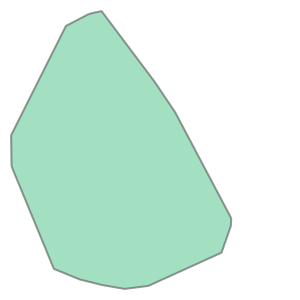

In [17]:
hull

### Generate evenly spaced seed points

In [18]:
latmin, lonmin, latmax, lonmax = hull.bounds

In [19]:
# https://stackoverflow.com/questions/66010964/fastest-way-to-produce-a-grid-of-points-that-fall-within-a-polygon-or-shape
prep_polygon = prep(hull)
points = []
for lat in np.arange(latmin, latmax, seed_point_spacing):
    for lon in np.arange(lonmin, lonmax, seed_point_spacing):
        points.append(Point((round(lat,4), round(lon,4))))

In [20]:
valid_points = []
valid_points.extend(filter(prep_polygon.contains, points))

In [21]:
points_df = pd.DataFrame(valid_points, columns=['Points'])

In [22]:
points_df

,Points
0,POINT (900987.1696 6765923.1417)
1,POINT (900987.1696 6766923.1417)
2,POINT (900987.1696 6767923.1417)
3,POINT (900987.1696 6768923.1417)
4,POINT (900987.1696 6769923.1417)
...,...
298,POINT (917987.1696 6764923.1417)
299,POINT (917987.1696 6765923.1417)
300,POINT (918987.1696 6761923.1417)
301,POINT (918987.1696 6762923.1417)


In [23]:
points_gdf = gpd.GeoDataFrame(points_df, crs=proj_crs, geometry='Points')

In [24]:
points_gdf.to_crs(proj_crs)

,Points
0,POINT (900987.17 6765923.142)
1,POINT (900987.17 6766923.142)
2,POINT (900987.17 6767923.142)
3,POINT (900987.17 6768923.142)
4,POINT (900987.17 6769923.142)
...,...
298,POINT (917987.17 6764923.142)
299,POINT (917987.17 6765923.142)
300,POINT (918987.17 6761923.142)
301,POINT (918987.17 6762923.142)


<Axes: >

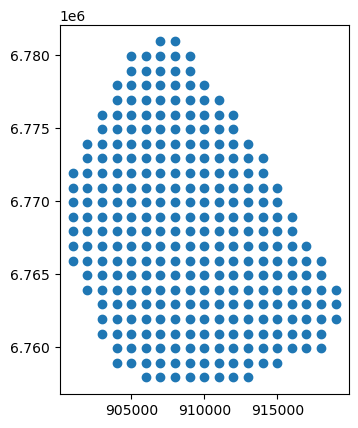

In [25]:
points_gdf.plot()

### Snap Seed points to OSM nodes

In [26]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
nA = np.array(list(points_gdf.geometry.apply(lambda x: (x.x, x.y))))
nB = np.array(list(nodes.geometry.apply(lambda x: (x.x, x.y))))
btree = cKDTree(nB)
dist, idx = btree.query(nA, k=1)
gdB_nearest = nodes.iloc[idx].drop(columns="geometry").reset_index(drop=True)
gdf = pd.concat(
    [
        points_gdf.reset_index(drop=True),
        gdB_nearest,
        pd.Series(dist, name='dist')
    ],
    axis=1)

In [27]:
gdf_cleaned = gdf.drop(gdf[gdf.dist > delta].index)
gdf_cleaned

,Points,y,x,street_count,highway,ref,osmID,dist
1,POINT (900987.17 6766923.142),51.816901,8.095518,4,NaN,NaN,393436154,259.423830
2,POINT (900987.17 6767923.142),51.820981,8.094855,4,NaN,NaN,415425854,163.667714
3,POINT (900987.17 6768923.142),51.826974,8.094031,1,NaN,NaN,1033524268,42.787350
4,POINT (900987.17 6769923.142),51.831652,8.096989,1,NaN,NaN,4914776240,407.465749
5,POINT (900987.17 6770923.142),51.837113,8.092713,1,NaN,NaN,8688519807,225.375513
...,...,...,...,...,...,...,...,...
297,POINT (917987.17 6763923.142),51.798508,8.247702,1,NaN,NaN,10270111698,205.893301
298,POINT (917987.17 6764923.142),51.804524,8.244668,1,NaN,NaN,3210015675,205.646126
300,POINT (918987.17 6761923.142),51.787468,8.252937,3,NaN,NaN,1321665769,305.969624
301,POINT (918987.17 6762923.142),51.794261,8.256002,1,NaN,NaN,12375995160,109.813961


In [28]:
snapped_points = nodes.loc[nodes['osmID'].isin(gdf_cleaned['osmID'])].copy()

In [29]:
snapped_points.drop(columns=['y', 'x','street_count', 'highway', 'ref'], inplace=True)

In [30]:
snapped_points

,geometry,osmID
osmid,,
111097062,POINT (907976.124 6757843.946),111097062
278351834,POINT (914844.325 6763930.873),278351834
278353908,POINT (910992.526 6762096.844),278353908
278355106,POINT (909998.076 6760645.723),278355106
278355124,POINT (912159.377 6761136.275),278355124
...,...,...
12460569942,POINT (915095.395 6766849.549),12460569942
12573586854,POINT (909234.791 6763846.163),12573586854
12870121474,POINT (914894.953 6765851.651),12870121474


<Axes: >

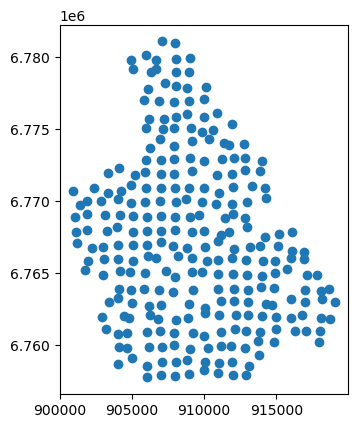

In [31]:
snapped_points.plot()

### Greedy triangulation

In [32]:
pairs = []
edges = []
distances = []

for pair in combinations(snapped_points["osmID"], 2):

    edge = LineString(snapped_points.loc[list(pair)].geometry)

    pairs.append(pair)
    edges.append(edge)
    distances.append(edge.length)

df = pd.DataFrame(
    {
        "pair": pairs,
        "e": edges,
        "dist": distances
    }
)

df = df.sort_values(by="dist", ascending=True).reset_index(drop=True)
df = df[df["dist"]>0].reset_index(drop=True) # only keep distances > 0
df.tail(10)

,pair,e,dist
34970,"(281837729, 8571582093)",LINESTRING (912884.7794277212 6757929.00754767...,23267.414435
34971,"(2702087981, 6360954799)",LINESTRING (906062.3640593719 6757758.16488605...,23329.436727
34972,"(3358885447, 6360954799)",LINESTRING (913134.3577260795 6758529.80940448...,23347.614223
34973,"(2457563812, 11940368273)",LINESTRING (911966.6051357092 6757933.82817607...,23351.443404
34974,"(3297963546, 6360954799)",LINESTRING (910981.9397118464 6758042.50892374...,23360.200947
34975,"(286933756, 8571582093)",LINESTRING (917953.2337671823 6760234.67382140...,23503.352423
34976,"(286933756, 6360954799)",LINESTRING (917953.2337671823 6760234.67382140...,23519.269941
34977,"(281837729, 11940368273)",LINESTRING (912884.7794277212 6757929.00754767...,23531.895224
34978,"(2457563812, 6360954799)",LINESTRING (911966.6051357092 6757933.82817607...,23652.772319
34979,"(281837729, 6360954799)",LINESTRING (912884.7794277212 6757929.00754767...,23865.706121


In [33]:
# helper function
def intersects_properly(geom1, geom2):
    '''
    for 2 shapely geometries, check whether they "properly intersect" (i.e. intersect but not touch, i.e. don't share endpoints)
    '''
    return geom1.intersects(geom2) and not geom1.touches(geom2)

In [34]:
# this should work, is suuuper slow tho (keyboard interrupt after 23 minutes)
# number of edges needs to be reduced

current_edges = MultiLineString()
edge_list = []

# go through all node pair combinations, if they dont intersect with existing edges add to multilinestring
for row in df.itertuples():
    new_edge = row.e
    pair = row.pair
    if not intersects_properly(current_edges, new_edge):
        current_edges = MultiLineString([linestring for linestring in current_edges.geoms] + [new_edge])
        edge_list.append(pair)

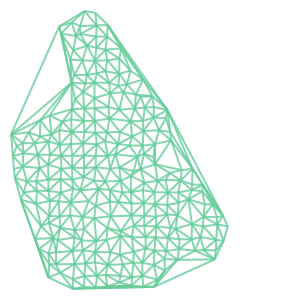

In [35]:
current_edges

In [36]:
A = nx.Graph()
A.add_nodes_from(snapped_points.index)
A.add_edges_from(edge_list)

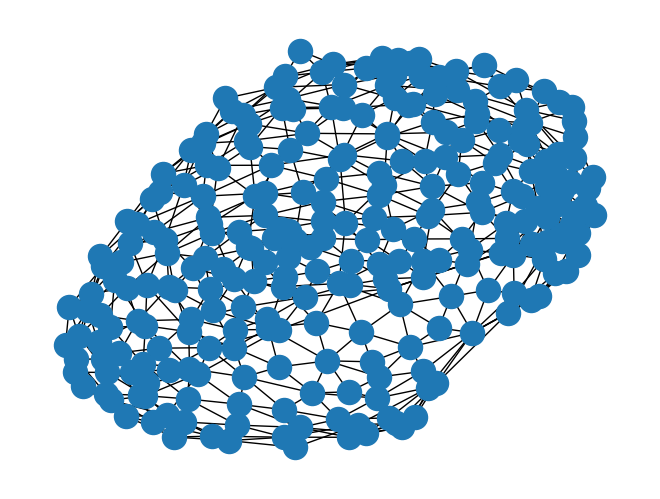

In [37]:
nx.draw(A)

### Add edge attribute betweenness to A

In [38]:
bc_values = nx.edge_betweenness_centrality(A, normalized=True)

In [39]:
nx.set_edge_attributes(A, bc_values, name='betweenness_centrality')

### Add node attribute closeness to A

In [40]:
closeness = nx.closeness_centrality(A)

In [41]:
nx.set_node_attributes(A, closeness, name='closeness_centrality')

### Export Edges, Nodes from A to df

In [42]:
# https://stackoverflow.com/questions/62383699/converting-networkx-graph-to-data-frame-with-its-attributes
def make_node_df(G):
    nodes = {}
    for node, attribute in G.nodes(data=True):
        if not nodes.get('node'):
            nodes['node'] = [node]
        else:
            nodes['node'].append(node)

        for key, value in attribute.items():
            if not nodes.get(key):
                nodes[key] = [value]
            else:
                nodes[key].append(value)

    return pd.DataFrame(nodes)

In [43]:
# https://stackoverflow.com/questions/62383699/converting-networkx-graph-to-data-frame-with-its-attributes
def make_edge_df(G):
    edges = {}
    for source, target, attribute in G.edges(data=True):
        if not edges.get('source'):
            edges['source'] = [source]
        else:
            edges['source'].append(source)

        if not edges.get('target'):
            edges['target'] = [target]
        else:
            edges['target'].append(target)
        for key, value in attribute.items():
            if not edges.get(key):
                edges[key] = [value]
            else:
                edges[key].append(value)
    return pd.DataFrame(edges)

In [44]:
a_edges = make_edge_df(A)

In [45]:
a_nodes = make_node_df(A)

### Rank edges by attribute

In [46]:
a_edges_ordered = a_edges.copy(deep=True)

In [47]:
a_edges_ordered = a_edges_ordered.sort_values(by='betweenness_centrality', ascending = False)

### Routing between seed points

In [48]:
a_edges_ordered

,source,target,betweenness_centrality
641,3642201401,6790573228,0.106669
736,6790573228,6838087229,0.091471
650,3950087388,8664760647,0.091307
126,393436154,3950087388,0.088274
580,2702087981,8664760647,0.087617
...,...,...,...
513,1386453958,12400601228,0.000304
596,2734126597,11940368273,0.000299
134,401330899,406720489,0.000281
483,859536791,3404445980,0.000257


In [49]:
paths = []
for _, row in a_edges_ordered.iterrows():
    source = row.source
    target = row.target
    try:
        path = nx.shortest_path(g, source, target, weight='length')
        paths.append(path)
    except:
        pass

In [50]:
paths = [[int(node) for node in y] for y in paths]

In [51]:
# found solution without zip, navigating edge reverse problem. nested for-loop is not nice tho, improvement needed
edge_tuples = []
for i in range(len(paths)):
    for j in range(len(g)):
        try:
            edge_tuple = paths[i][j], paths[i][j+1]
            edge_tuples.append(edge_tuple)
        except:
            pass

In [52]:
list_of_edges = []
for i in range(len(edge_tuples)):
    edge = g.get_edge_data(edge_tuples[i][0], edge_tuples[i][1])
    list_of_edges.append(edge)

In [53]:
routed_edges_df = pd.json_normalize(list_of_edges)
routed_edges_df = routed_edges_df.iloc[:,0:15].copy()
routed_edges_df.columns = ['osmid','highway','oneway','reversed','length','service', 'width','geometry','lanes','maxspeed','name','ref', 'bridge','junction', 'access']

In [54]:
routed_edges_df['path'] = pd.Series(edge_tuples)

In [55]:
#routed_edges_df.dropna(subset=['geometry'], inplace=True)

In [56]:
routed_edges_gdf = gpd.GeoDataFrame(routed_edges_df, crs=orig_crs, geometry='geometry')
routed_edges_gdf.to_crs(proj_crs, inplace=True)

In [57]:
routed_edges_gdf['path'] = routed_edges_gdf['path'].astype(str).copy()
routed_edges_gdf['path'] = routed_edges_gdf['path'].map(lambda x: x.lstrip('(').rstrip(')')).copy()

In [58]:
routed_edges_gdf[['source','target']] = pd.DataFrame(routed_edges_gdf.path.str.split(',',n=1, expand=True)).copy()
routed_edges_gdf['target'] = routed_edges_gdf['target'].str.strip().copy()
routed_edges_gdf['source'] = routed_edges_gdf['source'].str.strip().copy()
routed_edges_gdf['source'] = routed_edges_gdf['source'].str.lstrip('[').copy()
routed_edges_gdf['target'] = routed_edges_gdf['target'].str.rstrip(']').copy()

In [59]:
routed_edges_gdf['source'] = routed_edges_gdf['source'].astype(int)
routed_edges_gdf['target'] = routed_edges_gdf['target'].astype(int)

In [60]:
routed_edges_gdf

,osmid,highway,oneway,reversed,length,service,width,geometry,lanes,maxspeed,name,ref,bridge,junction,access,path,source,target
0,"[40122917, 40123021]","[service, track]",False,"[False, True]",187.452473,driveway,3.5,"LINESTRING (918661.504 6763882.668, 918643.27 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3642201401, 8448392590",3642201401,8448392590
1,40123021,service,False,True,72.590365,driveway,3.5,"LINESTRING (918503.052 6764133.276, 918497.308...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"8448392590, 482855664",8448392590,482855664
2,40123021,service,False,True,405.153229,driveway,3.5,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"482855664, 482855661",482855664,482855661
3,"[559061529, 850793028]",secondary,False,False,675.524710,NaN,6.2,"LINESTRING (918200.307 6764844.803, 917566.655...",2,100,Batenhorster Straße,L 586,NaN,NaN,NaN,"482855661, 445362160",482855661,445362160
4,559061529,secondary,False,False,517.944787,NaN,6.2,None,2,100,Batenhorster Straße,L 586,NaN,NaN,NaN,"445362160, 6038687702",445362160,6038687702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7384,631819307,service,False,True,138.716152,NaN,NaN,"LINESTRING (906881.854 6776692.991, 906739.02 ...",NaN,NaN,Am Hülsen,NaN,NaN,NaN,NaN,"472200081, 472200079",472200081,472200079
7385,631819307,service,False,True,546.942438,NaN,NaN,"LINESTRING (906659.326 6776665.299, 906618.394...",NaN,NaN,Am Hülsen,NaN,NaN,NaN,NaN,"472200079, 3404445980",472200079,3404445980
7386,"[47576409, 43179231]",unclassified,False,True,107.287568,NaN,NaN,"LINESTRING (901854.242 6769991.602, 901852.706...",1,NaN,Haus-Geist-Weg,NaN,NaN,NaN,NaN,"2304507007, 378375586",2304507007,378375586
7387,"[33291651, 694831646, 694831647]",unclassified,False,False,22.991244,NaN,NaN,"LINESTRING (901784.935 6770147.101, 901773.692...",1,NaN,NaN,NaN,yes,NaN,NaN,"378375586, 4914776223",378375586,4914776223


In [61]:
rank = []
for row in routed_edges_gdf.itertuples():
    source = row.source
    target = row.target
    for i in range(len(paths)):
        try:
           if source in paths[i] and target in paths[i]:
               rank.append(i)
               break
        except:
            pass

In [62]:
routed_edges_gdf['rank'] = rank

In [63]:
routed_edges_gdf

,osmid,highway,oneway,reversed,length,service,width,geometry,lanes,maxspeed,name,ref,bridge,junction,access,path,source,target,rank
0,"[40122917, 40123021]","[service, track]",False,"[False, True]",187.452473,driveway,3.5,"LINESTRING (918661.504 6763882.668, 918643.27 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3642201401, 8448392590",3642201401,8448392590,0
1,40123021,service,False,True,72.590365,driveway,3.5,"LINESTRING (918503.052 6764133.276, 918497.308...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"8448392590, 482855664",8448392590,482855664,0
2,40123021,service,False,True,405.153229,driveway,3.5,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"482855664, 482855661",482855664,482855661,0
3,"[559061529, 850793028]",secondary,False,False,675.524710,NaN,6.2,"LINESTRING (918200.307 6764844.803, 917566.655...",2,100,Batenhorster Straße,L 586,NaN,NaN,NaN,"482855661, 445362160",482855661,445362160,0
4,559061529,secondary,False,False,517.944787,NaN,6.2,None,2,100,Batenhorster Straße,L 586,NaN,NaN,NaN,"445362160, 6038687702",445362160,6038687702,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7384,631819307,service,False,True,138.716152,NaN,NaN,"LINESTRING (906881.854 6776692.991, 906739.02 ...",NaN,NaN,Am Hülsen,NaN,NaN,NaN,NaN,"472200081, 472200079",472200081,472200079,148
7385,631819307,service,False,True,546.942438,NaN,NaN,"LINESTRING (906659.326 6776665.299, 906618.394...",NaN,NaN,Am Hülsen,NaN,NaN,NaN,NaN,"472200079, 3404445980",472200079,3404445980,148
7386,"[47576409, 43179231]",unclassified,False,True,107.287568,NaN,NaN,"LINESTRING (901854.242 6769991.602, 901852.706...",1,NaN,Haus-Geist-Weg,NaN,NaN,NaN,NaN,"2304507007, 378375586",2304507007,378375586,340
7387,"[33291651, 694831646, 694831647]",unclassified,False,False,22.991244,NaN,NaN,"LINESTRING (901784.935 6770147.101, 901773.692...",1,NaN,NaN,NaN,yes,NaN,NaN,"378375586, 4914776223",378375586,4914776223,432


In [64]:
routed_edges_gdf.to_file('routed_edges_gdf.gpkg', driver='GPKG')

### Visualization

In [65]:
# viz/plot settings (move to config file later)

# define color palette (from Michael's project: https://github.com/mszell/bikenwgrowth/blob/main/parameters/parameters.py)
streetcolor = "#999999"
edgecolor = "#0EB6D2"
seedcolor = "#ff7338"

# define linewidths

lws = {
   "street": 0.75,
   "bike": 2
}

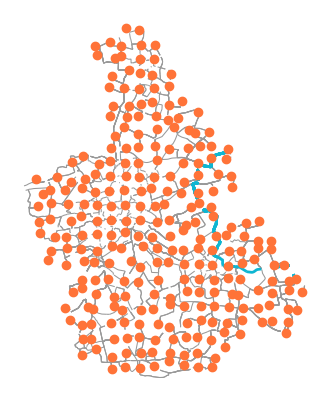

In [66]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

# first, plot street network as "base line"
routed_edges_gdf.plot(
    ax=ax,
    color=streetcolor,
    lw=lws["street"],
    zorder=0
)

# plot all edges up to maxrank
maxrank = 0

routed_edges_gdf[routed_edges_gdf["rank"]<=maxrank].plot(
    ax=ax,
    color=edgecolor,
    lw=lws["bike"],
    zorder=1
)

snapped_points.plot(
    ax=ax,
    color=seedcolor,
    zorder=2
)

ax.set_axis_off()


In [67]:
import os

os.makedirs("./results/", exist_ok=True)
os.makedirs("./results/plots/", exist_ok=True)
os.makedirs("./results/plots/video/", exist_ok=True)

In [72]:
for rank in range(0,770):

    fig, ax = plt.subplots(1,1, figsize=(10,10))

    # first, plot street network as "base line"
    routed_edges_gdf.plot(
        ax=ax,
        color=streetcolor,
        lw=lws["street"],
        zorder=0
    )

    # plot all edges up to current rank

    routed_edges_gdf[routed_edges_gdf["rank"]<=rank].plot(
        ax=ax,
        color=edgecolor,
        lw=lws["bike"],
        zorder=1
    )

    snapped_points.plot(
        ax=ax,
        color=seedcolor,
        zorder=2
    )

    ax.set_axis_off()

    plot_id = "{:03d}".format(rank) # format plot ID with leading zeros

    fig.savefig(f"./results/plots/{plot_id}.png", dpi=300)

    plt.close()

In [73]:
def make_video(
        img_folder_name, # folder where imgs are stored
        fps = 1 # files per second
        ):

    l = glob.glob(f"{img_folder_name}/*.png") # list of filenames

    # assuming the files are called "000.png", "001.png", etc.;
    # to plot them in the right order:
    # remove ".png" from filenames;
    # then, convert filenames to integer
    m = [int(re.findall(r'\d+.png', item)[0].replace(".png", "")) for item in l]
    # and finally, sort:
    images = [l[i] for i in np.argsort(m)]

    # make a "video" subfolder in images folder
    os.makedirs(pathlib.Path(img_folder_name, "video"), exist_ok=True)

    # define file name for video
    video_name = str(pathlib.Path(img_folder_name, "video", "video.mp4"))

    # if there was already such a file - remove it
    if os.path.exists(video_name):
        os.remove(video_name)
        print("\t previous video removed")

    # generate frame in cv2
    frame = cv2.imread(images[0])
    height, width, _ = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(
        video_name,
        fourcc,
        fps, # frames per second = this is the speed of our video
        (width,height)
    )

    # add images as separate frames
    for image in images:
        video.write(
            cv2.resize(
                cv2.imread(image),
                (width, height)
                ),
        )
    cv2.destroyAllWindows()

    # save
    video.release()

    return None

In [74]:
make_video(
    img_folder_name="./results/plots/",
    fps = 1
)

	 previous video removed
